# __Reviewer feedback analysis 2__

On:
- Country topical enrichment statistics
- UMAP representation of records year-by-year

## ___Set up___

In [147]:
# For topic enrichment per country p-value multiple testing correction
from statsmodels.stats.multitest import multipletests

# For umap
import pickle, umap
import numpy as np
import pandas as pd
import umap.plot
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import colors

# for animated gif
import imageio

# for movie
import cv2

from tqdm import tqdm

proj_dir = Path.home() / "projects/plant_sci_hist"

## ___Statistical significance of topical enrichment___

Reviewer 1:

"For Figure 5F it is not clear which of the changes are statistically significant, particularly if controlling for testing of multiple hypotheses."

Response: We have conduct statistical tests on these but did not report the results. They are now incorporated and we modified the figure to indicate significant differences after multiple testing corrections.


### Multiple testing correction

In [10]:
# stat is already generated, but not multiple-testing corrected

# Get the p-values
dir75     = proj_dir / "7_countries/7_5_country_over_time"
pval_file = dir75 / "country_top10_toc_pval.csv"

pval_df = pd.read_csv(pval_file, index_col=[0])
pval_df.head(2)

,toc_name,CHN,USA,JPN,DEU,FRA,GBR,IND,ESP,ITA,AUS
toc,,,,,,,,,,,
0,allergen | pollen | ige | allergenic,4.535153e-42,1.609574e-17,0.885126,1.095708e-12,0.026466,0.000007,7.769514e-01,1.318535e-47,6.467812e-08,0.321514
1,medium | callus | regeneration | culture | som...,3.583564e-38,1.828608e-05,0.538833,4.987797e-18,0.209628,0.018076,5.853805e-186,6.176955e-03,7.353872e-03,0.000003


In [32]:
countries = pval_df.columns[1:]
countries

Index(['CHN', 'USA', 'JPN', 'DEU', 'FRA', 'GBR', 'IND', 'ESP', 'ITA', 'AUS'], dtype='object')

In [33]:
# correct for each country
pval_corrected = []
for country in countries:
  pval = pval_df[country].values
  pval_corrected.append(multipletests(pval, method='fdr_bh')[1])

len(pval_corrected)

10

In [34]:
# Turn into np array than transpose
pval_corrected_arr = np.array(pval_corrected).T

# Convert to dataframe
pval_corrected_df = pd.DataFrame(pval_corrected_arr, columns=list(countries),
                                 index=pval_df.index)
print(pval_corrected_df.shape)

# output to csv
pval_corrected_df.to_csv(dir75 / "country_top10_toc_pval_corrected.csv")

(90, 10)


### Get corrected p-values for Fig 5F

In [35]:
# country order
c_order = ["JPN", "GBR", "DEU", "FRA", "USA", "AUS", "ESP", "ITA", "CHN", "IND"]

# topic order
t_order = [1, 69, 30, 9, 23, 28, 75, 86, 83, 21, 0, 54, 51]

In [42]:
# [[pval_country1], [pval_country2], ...]]
pvals_list = []
for c in c_order:
  pvals = []
  for t in t_order:
    pvals.append(pval_corrected_df.loc[t, c])
  pvals_list.append(pvals)


In [44]:
# Convert to np array
pvals_arr = np.array(pvals_list).T

# Convert to dataframe
pvals_df = pd.DataFrame(pvals_arr, columns=c_order, index=t_order)

# output to csv
pvals_df.to_csv(dir75 / "country_top10_toc_pval_corrected_Fig5F.csv")

In [45]:
pvals_df.head(5)

,JPN,GBR,DEU,FRA,USA,AUS,ESP,ITA,CHN,IND
1,5.638950e-01,2.324108e-02,1.603221e-17,2.482440e-01,2.420217e-05,8.656122e-06,1.010774e-02,1.121777e-02,7.167128e-38,2.634212e-184
69,5.984807e-152,1.680876e-73,1.956934e-30,2.080004e-24,1.110435e-218,2.532725e-22,2.692763e-36,8.805576e-01,3.044451e-203,6.775499e-01
30,1.693636e-40,8.094176e-02,1.119947e-01,7.084776e-02,4.823607e-07,2.079011e-01,2.241177e-01,2.950271e-02,2.599642e-09,1.119393e-01
9,1.079546e-14,7.847829e-10,1.054466e-08,4.100327e-06,2.153816e-20,9.293587e-01,3.920159e-02,5.861011e-01,7.847940e-162,1.830068e-07
23,1.810340e-39,4.011821e-37,2.889594e-43,1.463937e-12,1.889890e-62,2.058462e-08,6.329757e-18,7.114919e-07,0.000000e+00,1.602068e-21


## ___Coloring UMAP graph based on years___

The projection of publications in a 2D space in Figure 1C is great but made me curious about seeing publication years superimposed. This would help to see how science shifted over the space of the corpus.

Response: We are also curious to find out after the reviewer raised this interesting point. We have now included a new Fig. SXX to generate the same plot by year.


### Folders and files

In [217]:
proj_dir     = Path.home() / "projects/plant_sci_hist"

dir42        = proj_dir / "4_topic_model/4_2_outlier_assign"
prob_file    = dir42 / "probs.pickle"

# Check which of the two correspond to the prob file because the plotting is 
# done based on the topic assignments using the prob files. Need to make sure 
# the number of records are consistent between prob file and the corpus file.
corpus_file1 = dir42 / "table4_2_corpus_with_topic_assignment.tsv.gz"
corpus_file2 = dir42 / "table7_5_corpus_with_topic_assignment_nodup.tsv.gz"

dir46       = proj_dir / "4_topic_model/4_6_umap"
mapper_file = dir46 / '_umap_nn40/mapper_topics_all.pickle'

work_dir    = proj_dir / "9_wrap_up/9_4_umap"
work_dir.mkdir(exist_ok=True)

out_dir = work_dir / "_umap_nn40_year"
out_dir.mkdir(exist_ok=True)

out_dir2 = work_dir / "_umap_nn40_year_topic"
out_dir2.mkdir(exist_ok=True)

out_dir3 = work_dir / "_umap_nn40_year_topic_clus"
out_dir3.mkdir(exist_ok=True)

### Get the year array

In [4]:
# first check the size of prob, corpus file 1 and corpus file 2
with open(prob_file, 'rb') as f:
    probs = pickle.load(f)

corpus1 = pd.read_csv(corpus_file1, sep='\t', compression='gzip')
corpus2 = pd.read_csv(corpus_file2, sep='\t', compression='gzip')

probs.shape, corpus1.shape, corpus2.shape

((421658, 90), (421658, 13), (421307, 13))

In [5]:
# Ok, the prob is based on the original with some duplicates
# Also, check 4_6 and the topical assignment is consistent
corpus1.head()

,Unnamed: 0,Index_1385417,PMID,Date,Journal,Title,Abstract,Initial filter qualifier,Corpus,reg_article,Text classification score,Preprocessed corpus,Topic
0,0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,identification 120 mus phase decay delayed flu...,52
1,1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,cholinesterases plant tissues . vi . prelimina...,48
2,2,9,283,1975-01-01,Folia microbiologica,"Fructose 1,6-bisphosphate aldolase activity of...",FDP aldolase was found to be present in the ce...,sesbania,"Fructose 1,6-bisphosphate aldolase activity of...",1,0.901070,"fructose 1,6-bisphosphate aldolase activity rh...",48
3,3,14,380,1975-07-01,Journal of biochemistry,Studies on trypsin inhibitor in barley. I. Pur...,To clarify the properties and functions of a t...,barley,Studies on trypsin inhibitor in barley. I. Pur...,1,0.894069,studies trypsin inhibitor barley . i. purifica...,48
4,4,17,385,1975-11-10,The Journal of biological chemistry,Reconstitution of ion transport and respirator...,Reduced coenzyme Q-cytochrome c reductase from...,soybean,Reconstitution of ion transport and respirator...,1,0.827328,reconstitution ion transport respiratory contr...,47


In [6]:
yr_array = np.array([int(x.split("-")[0]) for x in corpus1["Date"]])

yr_array[:5], yr_array.shape

(array([1975, 1975, 1975, 1975, 1975]), (421658,))

### Read mapper obj

In [7]:
# This object cannot be loaded when I created a new environment on 2/14/2024
# due to issue with numba. Use an older environment with the following:
#   umap=0.5.2
#   numba=0.55.0
# There may be other dependancies not listed here.

with open(mapper_file, "rb") as f:
  mapper = pickle.load(f)

Thu Feb 22 13:03:40 2024 Building and compiling search function


In [8]:
dir(mapper)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '_a',
 '_b',
 '_check_custom_metric',
 '_check_feature_names',
 '_check_n_features',
 '_densmap_kwds',
 '_disconnection_distance',
 '_fit_embed_data',
 '_get_param_names',
 '_get_tags',
 '_initial_alpha',
 '_input_distance_func',
 '_input_hash',
 '_inverse_distance_func',
 '_knn_dists',
 '_knn_indices',
 '_knn_search_index',
 '_metric_kwds',
 '_more_tags',
 '_n_neighbors',
 '_original_n_threads',
 '_output_distance_func',
 '_output_metric_kwds',
 '_populate_combined_params',
 '_raw_data',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_rho

In [9]:
# mapper._knn_dists.shape # <---  421658 x 40
# mapper._raw_data.shape  # <---- 421658 x 768
# mapper.graph_.shape     # <---- 421658 x 421658, sparse matrix

### Plotting trial 1

Lifted from 4_6. But these are deprecated to use a custom one so the point size can be controlled.

In [10]:
help(umap.plot.points)

Help on function points in module umap.plot:

points(umap_object, labels=None, values=None, theme=None, cmap='Blues', color_key=None, color_key_cmap='Spectral', background='white', width=800, height=800, show_legend=True, subset_points=None, ax=None, alpha=None)
    Plot an embedding as points. Currently this only works
    for 2D embeddings. While there are many optional parameters
    to further control and tailor the plotting, you need only
    pass in the trained/fit umap model to get results. This plot
    utility will attempt to do the hard work of avoiding
    overplotting issues, and make it easy to automatically
    colour points by a categorical labelling or numeric values.
    
    This method is intended to be used within a Jupyter
    notebook with ``%matplotlib inline``.
    
    Parameters
    ----------
    umap_object: trained UMAP object
        A trained UMAP object that has a 2D embedding.
    
    labels: array, shape (n_samples,) (optional, default None)
        A

In [11]:
# get colors
def get_ckeys():
  cm = plt.cm.rainbow
  ckeys = {i:colors.to_hex(cm(i/91)) for i in range(-1,91)}
  return ckeys

In [12]:
def umap_plot_each(out_dir, mapper, labels, year, c_fg, c_bg):
  '''Do umap plot for each year, lifted from 4.6.
  Args:
    out_dir (Path): directory where the plots will be saved
    mapper (umap.umap_.UMAP): mapper object
    labels (list): list of labels for the mapping (1 for the topic of interest,
      0 for all other topics)
    topic (int): topic info to be included in the title
    c_fg (str): color for the topic
    c_bg (str): color for all other topics
  '''
  
  color_key={f"year={year}":c_fg, "all_others":c_bg}

  #fig, ax = plt.subplots()
  #ax.plot(marker=".", marker_size=20)

  umap.plot.points(mapper, labels=labels, color_key=color_key, alpha=1)
  mapper_year_plot = out_dir / f'fig_9_4_mapper_year_{year}.jpg'
  plt.title(f'Year {year}')
  plt.savefig(mapper_year_plot)
  plt.close()
  
  return mapper_year_plot


In [13]:
def plot_each(out_dir, mapper, yr_array, ckeys, c_fg="red", c_bg="white",
              test_plot=0):
  ''' Go through years
  Args:
    out_dir (Path): directory of mapper object
    mapper (UMAP): mapper object
    yr_array (Numpy array): int array with years
    ckeys (array): array of colors
    c_fg (str): foreground color, if not set, all topic colors will be the same
    c_bg (str): background color, default lightgray
  '''
  c = 0

  plots = {} # {year: ax}
  for year in tqdm(range(1975, 2021)):

    yr_labels = []

    if c_fg == "":
      c_fg = ckeys[year+1]

    # Modify labels
    for label in yr_array:
      if label == year:
        yr_labels.append(f"year={year}")
      else:
        yr_labels.append("all_others")

    # Change label list into an array for umap.plot
    labels_array =  np.array(yr_labels)

    # Plotting
    fig_file = umap_plot_each(out_dir, mapper, labels_array, year, 
                                  c_fg, c_bg)
    
    plots[year] = fig_file
    
    if test_plot and c == 5:
      break
    c += 1

  return plots

In [14]:
ckeys = get_ckeys()

plots = plot_each(out_dir, mapper, yr_array, ckeys)

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:58<00:00,  1.27s/it]


In [15]:
### Generate animated gif
images = []

filenames = [plots[year] for year in plots]

for filename in filenames:
  images.append(imageio.imread(filename))
imageio.mimsave(out_dir / '_movie.gif', images, fps=1)

### Deal with faint earlier time points: all data

There are too few data points so it is hard to see things. Peek into the `umap.plot.points` function to see what can be done.

Turn out that the original function is just calling plt.scatter.

In [16]:
umap_embed = mapper.embedding_
umap_embed.shape, type(umap_embed)

((421658, 2), numpy.ndarray)

In [36]:
# Get boundary info
[x_max, y_max] = list(np.max(umap_embed, axis=0))
[x_min, y_min] = list(np.min(umap_embed, axis=0))

In [144]:
# Set point sizes, this is not used
n_years = len(range(1975, 2021))
p_sizes = np.linspace(2, 0.01, n_years)

n_years, len(p_sizes)


(46, 46)

In [145]:
plots_all_blue = {}

for idx, year in enumerate(range(1975, 2021)):

  # indices of rows of the year
  yr_idx = np.where(yr_array == year)
  print(idx, year, len(yr_idx[0]))

  # 1176 is the number of records in 1975 which is the fewest. The value is
  # normalized by the number of records in the year:
  # 1. Times the square of i+1 to account for increasing number of records over
  #    the years. But the square is too much, 
  # 2. Just do i+1. Still too strong.
  # 3. Just do len(idx_yr).
  p_size = 2*1776/(len(idx_yr))

  # plot
  plt.figure(figsize=(10,10))
  plt.scatter(umap_embed[yr_idx,0], umap_embed[yr_idx,1], c="blue", 
              s=p_size)
  plt.title(f"Year {year}", fontsize=16)
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)

  # save
  plot_file = out_dir / f'fig_9_4_mapper_year_{year}.jpg'
  plt.savefig(plot_file)
  plt.close()

  plots_all_blue[year] = plot_file

0 1975 1176
1 1976 1210
2 1977 1184
3 1978 1301
4 1979 1276
5 1980 1440
6 1981 1548
7 1982 1748
8 1983 1893
9 1984 2132
10 1985 2195
11 1986 2336
12 1987 2520
13 1988 2666
14 1989 3103
15 1990 3474
16 1991 3696
17 1992 4016
18 1993 3943
19 1994 4209
20 1995 4489
21 1996 4764
22 1997 4187
23 1998 4766
24 1999 5142
25 2000 6778
26 2001 8216
27 2002 8964
28 2003 10461
29 2004 10060
30 2005 11576
31 2006 12000
32 2007 12653
33 2008 14499
34 2009 14056
35 2010 14493
36 2011 16296
37 2012 17537
38 2013 19052
39 2014 21484
40 2015 21460
41 2016 22608
42 2017 22989
43 2018 23935
44 2019 26963
45 2020 30228


In [146]:
### Generate animated gif
filenames = [plots_all_blue[year] for year in plots_all_blue]

images = []
for filename in filenames:
  images.append(imageio.imread(filename))
imageio.mimsave(out_dir / '_movie_all_blue.gif', images)

In [157]:
### Generate movie
# https://stackoverflow.com/questions/68716626/how-can-i-create-an-mp4-out-of-an-image-sequance

def generate_movie(plot_files, out_file):
  frame_per_second = 40
  files_and_duration = [(plot_files[year], 0.1) for year in plot_files]

  w, h = None, None
  movie_file = str(out_file)
  for file, duration in files_and_duration:
    frame = cv2.imread(str(file))

    if w is None:
      # Setting up the video writer
      h, w, _ = frame.shape
      fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
      writer = cv2.VideoWriter(movie_file, fourcc, frame_per_second, (w, h))

    # Repating the frame to fill the duration
    frame_sec = int(duration * frame_per_second)
    for _ in range(frame_sec):
      writer.write(frame)

  writer.release()

In [158]:
out_file_all_blue = out_dir / '_movie_all_blue.mp4'
generate_movie(plots_all_blue, out_file_all_blue)

### Plot per year, per topic

In [55]:
# Topic assignments
with open(prob_file, "rb") as f:
  probs = pickle.load(f)

probability_threshold = np.percentile(probs, 95)
topics_assign = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                        for prob in tqdm(probs)]
topics_assign[:10]

100%|██████████| 421658/421658 [00:03<00:00, 105862.91it/s]


[52, 48, 48, 48, 47, 32, 24, 48, 47, 52]

In [59]:
def get_ckeys():
  cm = plt.cm.rainbow
  #cm = plt.cm.turbo
  #cm = plt.cm.hsv
  ckeys = {i:colors.to_hex(cm(i/91)) for i in range(-1,91)}
  return ckeys

ckeys = get_ckeys()
ckeys[-1] = 'lightgray'
ckeys[0], ckeys[1]

('#8000ff', '#7c06ff')

In [159]:
# color for each record based on topic
rec_toc_c = [ckeys[i] for i in topics_assign]

In [163]:
legend_elements = []
for k, v in ckeys.items():
  legend_elements.append(plt.Line2D([0], [0], marker='o', color=v, 
                                    markerfacecolor=v, markersize=10, label=k))


In [166]:
reverse_ckeys = {v:k for k, v in ckeys.items()}

In [183]:
# Get total for each topic
topic_total = {}
for t in range(90):
  topic_total[t] = len(np.where(np.array(topics_assign) == t)[0])

topic_total

{0: 895,
 1: 2917,
 2: 1098,
 3: 751,
 4: 4616,
 5: 620,
 6: 1977,
 7: 1344,
 8: 1057,
 9: 1038,
 10: 1189,
 11: 3338,
 12: 9471,
 13: 2405,
 14: 1791,
 15: 3448,
 16: 2013,
 17: 1782,
 18: 3054,
 19: 3752,
 20: 2285,
 21: 789,
 22: 3468,
 23: 4405,
 24: 5486,
 25: 4700,
 26: 3956,
 27: 6163,
 28: 6680,
 29: 3445,
 30: 1472,
 31: 4950,
 32: 8251,
 33: 4640,
 34: 2470,
 35: 13599,
 36: 1358,
 37: 3329,
 38: 2294,
 39: 3785,
 40: 1686,
 41: 2916,
 42: 9745,
 43: 4282,
 44: 5007,
 45: 2356,
 46: 6956,
 47: 3009,
 48: 10369,
 49: 3633,
 50: 4927,
 51: 3408,
 52: 3857,
 53: 2552,
 54: 1917,
 55: 5961,
 56: 1665,
 57: 828,
 58: 2960,
 59: 2973,
 60: 3425,
 61: 16183,
 62: 1998,
 63: 2842,
 64: 5821,
 65: 3596,
 66: 673,
 67: 3862,
 68: 2892,
 69: 9471,
 70: 7180,
 71: 2465,
 72: 9951,
 73: 5590,
 74: 4384,
 75: 3181,
 76: 3765,
 77: 2622,
 78: 1364,
 79: 10390,
 80: 3229,
 81: 10403,
 82: 2980,
 83: 8930,
 84: 7289,
 85: 5989,
 86: 4315,
 87: 3737,
 88: 3807,
 89: 3008}

In [224]:
plots_topic_color = {}
for i, year in enumerate(range(1975, 2021)):

  # indices of rows not belong to the year
  idx_yr     = np.where(yr_array == year)[0]
  print(i, year, len(idx_yr))

  # get the colors for the records in the year
  c_year = [rec_toc_c[i] for i in idx_yr]

  # get the embedding values for the year
  e_year = umap_embed[idx_yr, :]

  # point size
  p_size = 2*1776/(len(idx_yr))

  # Experiment with plotting centroid. This works but no useful because I cannot
  # set the threshold to plot a topic

  # Plot topics
  plt.figure(figsize=(20,20))
  plt.scatter(e_year[:,0], e_year[:,1], c=c_year, s=p_size)
  plt.title(f"Year {year}", fontsize=16)
  #plt.legend(handles=legend_elements, loc="lower right", ncol=3)
  '''
  # Plot centroids
  # Get centroid for each topic, a list of [topic, x, y]
  centroids = []
  for t in range(90):
    # https://stackoverflow.com/questions/16343752/numpy-where-function-multiple-conditions
    idx = np.where((np.array(topics_assign) == t) & (yr_array == year))[0]
    #print(t, len(idx), len(idx)/topic_total[t])
    if len(idx)/len(idx_yr) > 0.05:
      xy = list(np.mean(umap_embed[idx], axis=0))
      centroids.append([t] + (xy))

  centroids = np.array(centroids)
  #print(centroids)

  cent_color = [ckeys[t] for t in centroids[:,0]]
  
  plt.scatter(centroids[:,1], centroids[:,2], c="black", s=800)
  for x in range(len(centroids)):
    plt.text(centroids[x,1]-0.1, centroids[x,2]-0.1, int(centroids[x,0]), 
             c="white", fontsize=20)
  '''
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)

  # save
  plot_file = out_dir2 / f'fig_9_4_mapper_year_{year}.jpg'
  plt.savefig(plot_file)
  plt.close()

  plots_topic_color[year] = plot_file

0 1975 1176
1 1976 1210
2 1977 1184
3 1978 1301
4 1979 1276
5 1980 1440
6 1981 1548
7 1982 1748
8 1983 1893
9 1984 2132
10 1985 2195
11 1986 2336
12 1987 2520
13 1988 2666
14 1989 3103
15 1990 3474
16 1991 3696
17 1992 4016
18 1993 3943
19 1994 4209
20 1995 4489
21 1996 4764
22 1997 4187
23 1998 4766
24 1999 5142
25 2000 6778
26 2001 8216
27 2002 8964
28 2003 10461
29 2004 10060
30 2005 11576
31 2006 12000
32 2007 12653
33 2008 14499
34 2009 14056
35 2010 14493
36 2011 16296
37 2012 17537
38 2013 19052
39 2014 21484
40 2015 21460
41 2016 22608
42 2017 22989
43 2018 23935
44 2019 26963
45 2020 30228


In [225]:
### Generate animated gif
filenames = [plots_topic_color[year] for year in plots_topic_color]

images = []
for filename in filenames:
  images.append(imageio.imread(filename))
imageio.mimsave(out_dir2 / '_movie.gif', images, fps=1)

In [226]:
### generate movie

out_file_topic_color = out_dir2 / '_movie_topic_color.mp4'
generate_movie(plots_topic_color, out_file_topic_color)

### Based on students' suggestion, focus on specific topics

Two clusters to illustrate topical succession:
- Cluster a
  - 19
  - 25
  - 26
  - 27
- Cluster b
  - 24
  - 28
  - 29
  - 30
  - 42
  - 47

In [139]:
#c_clust_keys = \
#  {19: 'lightcoral', 25: 'brown', 26: 'orange', 9: 'gold', 23: 'red',
#   47: "cyan", 29:"deepskyblue", 30:"blue", 24:"blueviolet", 42:"violet"}

#c_clust_keys = \
#  {47: "cyan", 29:"deepskyblue", 30:"blue", 24:"blueviolet", 42:"violet"}

c_clust_keys = \
  {47: "orange", 29:"red", 30:"violet", 24:"blue", 42:"cyan"}

c_list = list(c_clust_keys.values())
c_list

['orange', 'red', 'violet', 'blue', 'cyan']

In [227]:
plots_topic_clus = {}

# https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
legend_elements = []
for k, v in c_clust_keys.items():
  legend_elements.append(plt.Line2D([0], [0], marker='o', color=v, 
                                    markerfacecolor=v, markersize=10, label=k))

for i, yr in enumerate(range(1975, 2021)):
  i_yr_clus = []
  c_yr_clus = []
  for i in range(len(topics_assign)):
    topic = topics_assign[i]
    if topic in c_clust_keys and yr_array[i] == yr:
      i_yr_clus.append(i)
      c_yr_clus.append(c_clust_keys[topic])
  print(yr, len(i_yr_clus), len(c_yr_clus))

  e_yr_clus = umap_embed[i_yr_clus, :]

  p_size = 2*1776/(len(idx_yr))

  plt.figure(figsize=(10,10))
  plt.scatter(e_yr_clus[:,0], e_yr_clus[:,1], c=c_yr_clus, s=2)
  plt.title(f"Year {yr}", fontsize=16)
  plt.legend(handles=legend_elements, loc="upper left")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)

  # save
  plot_file = out_dir3 / f'fig_9_4_mapper_year_{yr}.jpg'
  plt.savefig(plot_file)
  plt.close()

  plots_topic_clus[yr] = plot_file

1975 34 34
1976 39 39
1977 35 35
1978 41 41
1979 52 52
1980 39 39
1981 73 73
1982 58 58
1983 70 70
1984 88 88
1985 75 75
1986 80 80
1987 83 83
1988 108 108
1989 93 93
1990 121 121
1991 110 110
1992 131 131
1993 115 115
1994 149 149
1995 150 150
1996 173 173
1997 155 155
1998 190 190
1999 207 207
2000 271 271
2001 276 276
2002 391 391
2003 405 405
2004 477 477
2005 524 524
2006 609 609
2007 687 687
2008 738 738
2009 731 731
2010 790 790
2011 983 983
2012 1047 1047
2013 1192 1192
2014 1363 1363
2015 1548 1548
2016 1549 1549
2017 1527 1527
2018 1592 1592
2019 1772 1772
2020 2098 2098


In [228]:
### Generate animated gif
filenames = [plots_topic_clus[year] for year in plots_topic_clus]

images = []
for filename in filenames:
  images.append(imageio.imread(filename))
imageio.mimsave(out_dir3 / '_movie.gif', images)

In [ ]:
### generate movie

out_file_topic_clus = out_dir3 / '_movie_topic_clus_color.mp4'
generate_movie(plots_topic_clus, out_file_topic_clus)

## ___Testing___

### UMAP plot

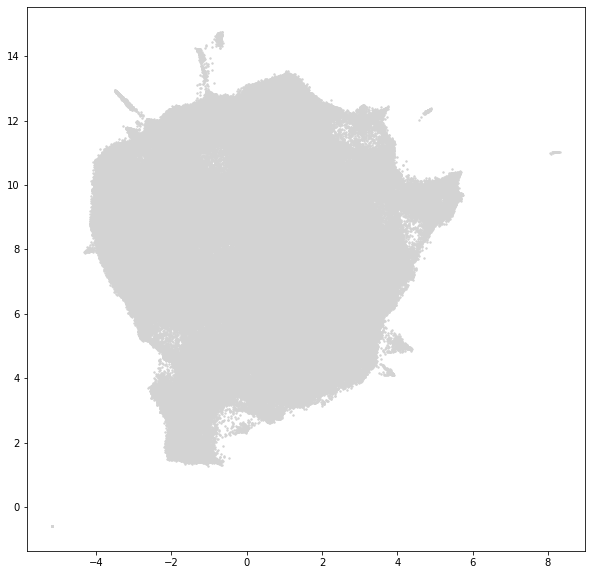

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(umap_embed[:,0], umap_embed[:,1], c="lightgray", s=2)

1975


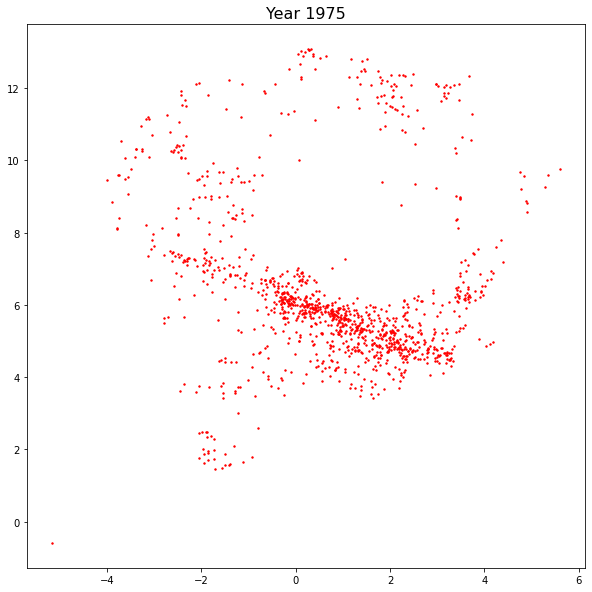

In [32]:
for year in range(1975, 2021):
  print(year)
  idx = np.where(yr_array == year)
  plt.figure(figsize=(10,10))
  plt.scatter(umap_embed[idx,0], umap_embed[idx,1], c="red", s=2)
  plt.title(f"Year {year}", fontsize=16)
  break

In [102]:
np.array(rec_toc_c)

array(['#a4f89f', '#8efeac', '#8efeac', ..., '#b4f295', '#d6db7e',
       '#6dfdbf'], dtype='<U9')

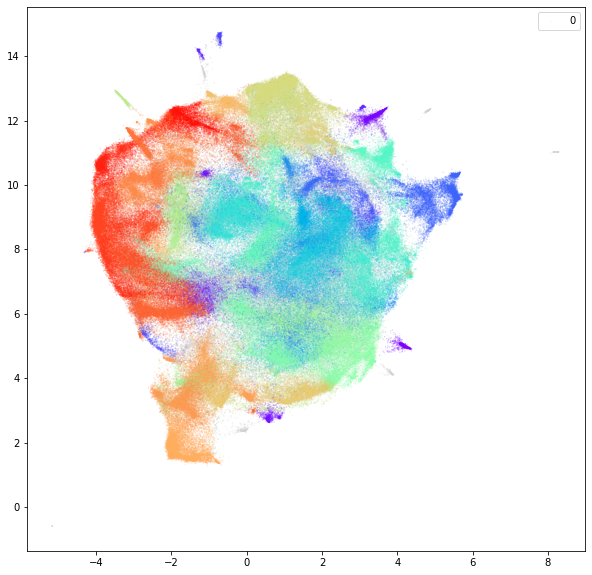

In [98]:
# Test plot all topics

plt.figure(figsize=(10,10))
plt.scatter(umap_embed[:,0], umap_embed[:,1], c=rec_top_c, s=0.01)

topics = range(91)
plt.legend(topics)

### Test plot for each year with topics in different colors

In [83]:
idx_not_yr = np.where(yr_array != 1975)[0]
rec_toc_c_copy = rec_toc_c.copy()

len(idx_not_yr), len(rec_toc_c_copy)

(420482, 421658)

In [84]:
# Change color to white for records that do not belong to 1975
for idx in idx_not_yr:
  rec_toc_c_copy[idx] = 'white'

In [85]:
not_in = [c for c in rec_toc_c_copy if c == 'white']
len(not_in)


420482

In [89]:
# Actually, I don't need to get not_in info, just get the colors for those
# in the year array
idx_in_yr = np.where(yr_array == 1975)[0]
rec_toc_c_copy = rec_toc_c.copy()

c_in_year = [rec_toc_c_copy[i] for i in idx_in_yr]
c_in_year[:5]

['#a4f89f', '#8efeac', '#8efeac', '#8efeac', '#88ffaf']

### Testing Gif with specific year and topics

2016 1290 1290


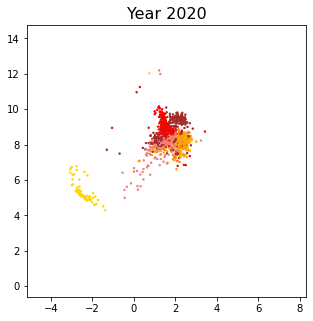

2017 1303 1303


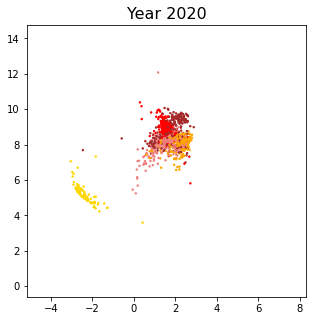

2018 1457 1457


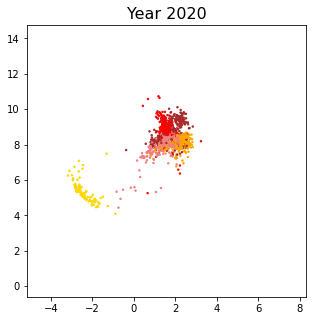

2019 1734 1734


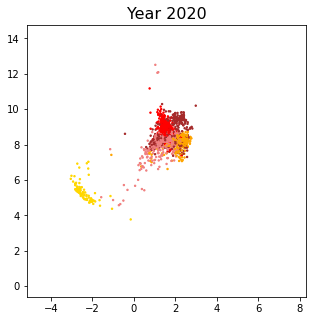

2020 1930 1930


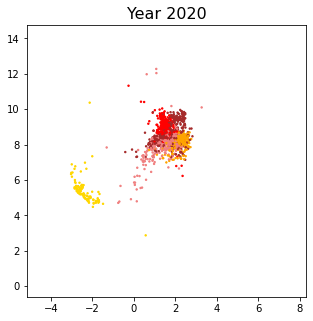

In [118]:
for yr in range(2016, 2021):
  i_yr_clus = []
  c_yr_clus = []
  for i in range(len(topics_assign)):
    topic = topics_assign[i]
    if topic in c_clust_keys and yr_array[i] == yr:
      i_yr_clus.append(i)
      c_yr_clus.append(c_clust_keys[topic])
  print(yr, len(i_yr_clus), len(c_yr_clus))

  e_yr_clus = umap_embed[i_yr_clus, :]

  plt.figure(figsize=(5,5))
  plt.scatter(e_yr_clus[:,0], e_yr_clus[:,1], c=c_yr_clus, s=2)
  plt.title(f"Year {year}", fontsize=16)
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.show()